# Sweep Line Voronoi Diagram (Fortune's Algorithm)

The Voronoi diagram is a partitioning of a plane into regions based on the distance to a specific point. Given a set of points, the Voronoi diagram is the set of points in the plane that are equidistant to the input points. The Voronoi diagram is also known as a Dirichlet tessellation.

In dimension 2, a Voronoi diagram of $n\geq 3$ sites has at most $2n-5$ vertices and $3n-6$ edges. The Voronoi diagram can be constructed in $O(n\log n)$ time using Fortune's algorithm.

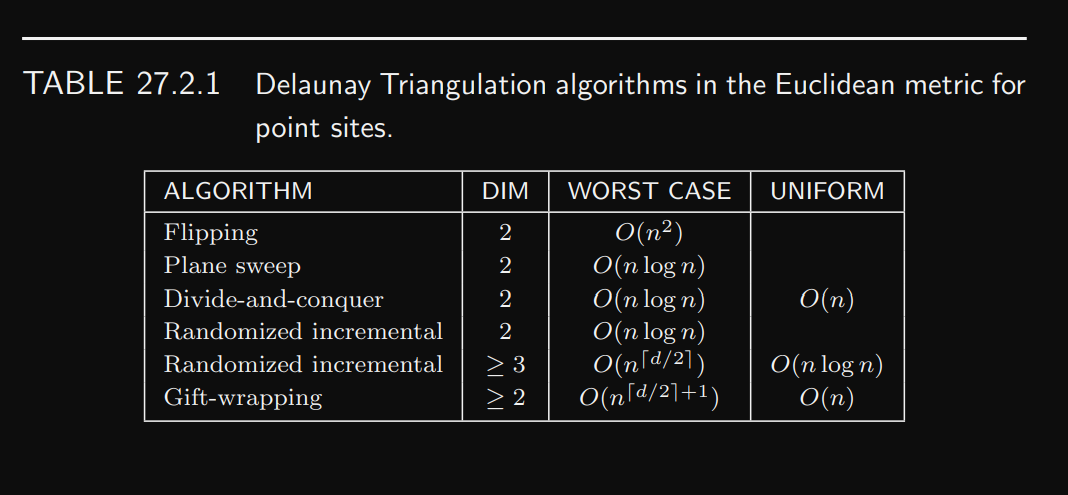

Reference:
- https://en.wikipedia.org/wiki/Fortune%27s_algorithm
- Handbook of DISCRETE AND COMPUTATIONAL GEOMETRY THIRD EDITION - Chapter 27 

In [19]:
import heapq
import random
from math import hypot
from typing import List, Tuple, TypeVar

# Define type aliases
ll = int
vi = List[int]
pii = Tuple[int, int]

# Define utility functions
def sz(x):
    return len(x)

def all(x):
    return x

# Define a helper function for the rep macro
def rep(start, end):
    return range(start, end)

T = TypeVar('T')

def minpq(items: List[T] = []):
    return heapq.heapify(items)

ftype = float
EPS = 1e-12
INF = 1e100

# Point class
class pt:
    def __init__(self, x: ftype = 0, y: ftype = 0):
        self.x = x
        self.y = y

    def __add__(self, o: 'pt') -> 'pt':
        return pt(self.x + o.x, self.y + o.y)

    def __sub__(self, o: 'pt') -> 'pt':
        return pt(self.x - o.x, self.y - o.y)

    def __mul__(self, f: ftype) -> 'pt':
        return pt(self.x * f, self.y * f)

    def rot(self) -> 'pt':
        return pt(-self.y, self.x)

    def dot(self, o: 'pt') -> ftype:
        return self.x * o.x + self.y * o.y

    def cross(self, o: 'pt') -> ftype:
        return self.x * o.y - self.y * o.x
    
    def gety(self) -> ftype:
        return self.y
    
    def len(self) -> ftype:
        return hypot(self.x, self.y)
    
    def __lt__(self, other):
        if self.y == other.y:
            return self.x < other.x
        return self.y < other.y
    
    def __eq__(self, other):
        return self.x == other.x and self.y == other.y
    
    def __hash__(self):
        return hash((self.x, self.y))
    
    def __repr__(self):
        return f"({self.x}, {self.y})"
    
# Utils functions for points
def collinear(a: pt, b: pt) -> bool:
    return abs(a.cross(b)) < EPS

def ccw(a: pt, b: pt, c: pt) -> bool:
    return (b - a).cross(c - a) > 0

def cw(a: pt, b: pt, c: pt) -> bool:
    return (b - a).cross(c - a) < 0

def lineline(a: pt, b: pt, c: pt, d: pt) -> pt:
    return a + (b - a) * ((c - a).cross(d - c) / (b - a).cross(d - c))

def circumcenter(a: pt, b: pt, c: pt) -> pt:
    b = (a + b) * 0.5;
    c = (a + c) * 0.5;
    return lineline(b, b + (b - a).rot(), c, c + (c - a).rot());

def circumcircle(a: pt, b: pt, c: pt) -> Tuple[pt, ftype]:
    center = circumcenter(a, b, c)
    return center, (a - center).len()

def generate_points(n):
    points = set()
    for _ in range(n):
        points.add(pt(random.uniform(0, 1000), random.uniform(0, 1000)))
    return list(points)

(76.73937237407401, 928.1699009674163) 96.32048695266741


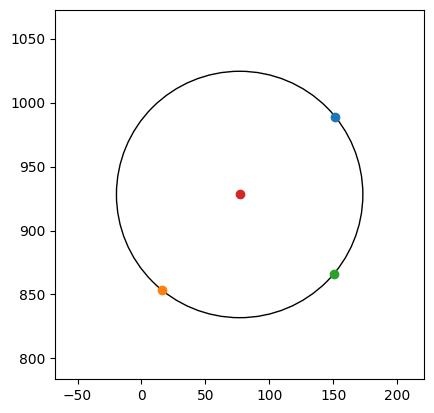

In [20]:
# Plot circumcircle
import matplotlib.pyplot as plt

points = generate_points(10)

center, radius = circumcircle(points[1], points[3], points[2])
print(center, radius)
circle = plt.Circle((center.x, center.y), radius, fill=False)
fig, ax = plt.subplots()
ax.add_artist(circle)
ax.set_xlim(center.x - 1.5*radius, center.x + 1.5*radius)
ax.set_ylim(center.y - 1.5*radius, center.y + 1.5*radius)
for p in [points[1], points[3], points[2], center]:
    plt.scatter(p.x, p.y)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [21]:
# Arc class
from math import sqrt

# TODO: Define sweepx as a global variable
sweepx = 320234.0

class Arc:
    def __init__(self, p, q, i):
        self.p = p
        self.q = q
        self.id = 0
        self.i = i

    def __hash__(self) -> int:
        return hash((self.p, self.q, self.id, self.i))

    def gety(self, x):
        if self.q.y == INF:
            return INF
        x += EPS
        med = (self.p + self.q) * 0.5
        dir = (self.p - med).rot()
        D = (x - self.p.x) * (x - self.q.x)
        if D < 0:
            return med.y
        if D == 0:
            return med.y + ((med.x - x) * dir.x) / dir.y
        if dir.y == 0:
            return INF
        return med.y + ((med.x - x) * dir.x + sqrt(D) * dir.len()) / dir.y

    def __lt__(self, other):
        if isinstance(other, float):
            return self.gety(sweepx) < other
        elif isinstance(other, Arc):
            return self.gety(sweepx) < other.gety(sweepx)
        else:
            raise TypeError("Unsupported operand type for <")
        
    def __eq__(self, other):
        return self.gety(sweepx) == other.gety(sweepx)


In [22]:
# Event class
class Event:
    def __init__(self, x: float, id: int, it: Arc):
        self.x = x
        self.id = id
        self.it = it

    def __lt__(self, other: 'Event') -> bool:
        return self.x < other.x


In [23]:
import heapq

class Fortune:
    def __init__(self, p: List[pt]):
        self.line = []  # beach line
        self.v = [(point, i) for i, point in enumerate(p)]  # (point, original index)
        self.Q = []  # priority queue of point and vertex events
        self.edges = []  # delaunay edges
        self.valid = []  # valid[-id] == True if the vertex event with corresponding id is valid
        self.n = len(p)  # number of points
        self.ti = 0  # next available vertex ID
        self.v.sort(key=lambda x: x[0].x)  # sort points by coordinate, remember original indices for the delaunay edges

    def upd(self, it: Arc):
        global sweepx
        if it.i == -1:  # doesn't correspond to a real point
            return
        self.valid[-it.id] = False  # mark existing remove event as invalid
        a = self.line[self.line.index(it) - 1]
        if collinear(it.q - it.p, a.p - it.p):  # doesn't generate a vertex event
            return
        self.ti -= 1  # new vertex event ID
        it.id = self.ti
        self.valid.append(True)  # label this ID true
        c = circumcenter(it.p, it.q, a.p)
        x = c.x + (c - it.p).len()
        # event is generated at time x.
        # make sure it passes the sweep-line, and that the arc truly shrinks to 0
        if x > sweepx - EPS and a.gety(x) + EPS > it.gety(x):
            heapq.heappush(self.Q, Event(x, it.id, it))

    def add_edge(self, i: int, j: int):
        if i == -1 or j == -1:
            return
        # Add edge in terms of original indices of vertices (v)
        self.edges.append((self.v[i][1], self.v[j][1]))

    def add(self, i: int):
        # print(f"Adding point {i}")
        # find arc to split
        c_arc = self.line[i]
        # insert new arcs. passing the following iterator gives a slight speed-up
        b = Arc(p, c_arc.p, i)
        self.line.insert(i, b)
        a = Arc(c_arc.p, p, c_arc.i)
        self.line.insert(self.line.index(b), a)
        self.add_edge(i, c_arc.i)
        self.upd(a)
        self.upd(b)
        self.upd(c_arc)

    def remove(self, it: Arc):
        idx = self.line.index(it)
        a = self.line[idx - 1]
        b = self.line[idx + 1]
        self.line.remove(it)
        a.q = b.p
        self.add_edge(a.i, b.i)
        self.upd(a)
        self.upd(b)

    def solve(self, X: float = 1e9):
        global sweepx
        # insert two points that will always be in the beach line,
        # to avoid handling edge cases of an arc being first or last
        X *= 3
        self.line.append(Arc(pt(-X, -X), pt(-X, X), -1))
        self.line.append(Arc(pt(-X, X), pt(INF, INF), -1))
        # print(f"Initial beach line: {self.line}")
        # create all point events
        for i in range(self.n-1, -1, -1):
            # print(f"Adding point event for point {i}")
            heapq.heappush(self.Q, Event(self.v[i][0].x, i, self.line[-1]))
        self.ti = 0
        self.valid = [False]
        while self.Q:
            e = heapq.heappop(self.Q)
            # print(f"Processing point {e.id}")
            sweepx = e.x
            if e.id >= 0:
                self.add(e.id)
            elif self.valid[-e.id]:
                self.remove(e.it)


In [25]:
points = generate_points(500)

In [26]:
from ctypes import *

# Load the shared library
lib = cdll.LoadLibrary('./voronoi.so')

# Define the function signature
# float* voronoiDiagramWrapper(float *xValues, float *yValues, int numValues, float minX, float maxX, float minY, float maxY, float minDistanceBetweenSites, GraphEdge **edges, int *numEdges)
lib.voronoiDiagramWrapper.argtypes = [POINTER(c_float), POINTER(c_float), c_int, c_float, c_float, c_float, c_float, c_float, POINTER(POINTER(c_void_p)), POINTER(c_int)]
lib.voronoiDiagramWrapper.restype = POINTER(c_float)

Generating Voronoi diagram from C++!


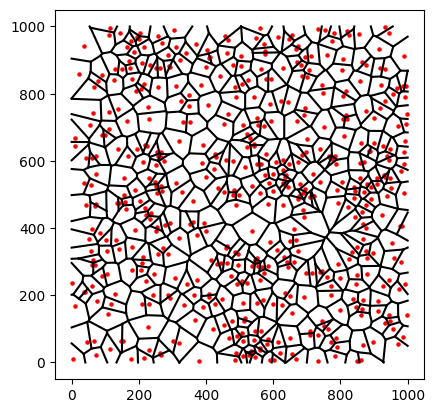

In [27]:
# Convert the points to a flat array
xValues = (c_float * len(points))()
yValues = (c_float * len(points))()

for i, p in enumerate(points):
    xValues[i] = p.x
    yValues[i] = p.y

# Call the function
edges = POINTER(c_void_p)()
numEdges = c_int(0)
result = lib.voronoiDiagramWrapper(xValues, yValues, len(points), 0, 1000, 0, 1000, 0, byref(edges), byref(numEdges))

# Extract the edges
n = int(result[0])
edges = []
for i in range(1, n * 4, 4):
    a = result[i]
    b = result[i + 1]
    c = result[i + 2]
    d = result[i + 3]
    edges.append((a, b, c, d))

# Plot the Voronoi diagram
for a, b, c, d in edges:
    plt.plot([a, c], [b, d], 'k-')

for p in points:
    plt.scatter(p.x, p.y, c='r', s=5)

plt.gca().set_aspect('equal', adjustable='box')
plt.show()
